In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [7]:
import os

file_paths = []
dir = './dataset1'
for filename in os.listdir(dir):
    file_paths.append('./dataset1/'+filename)

In [19]:
len(file_paths)

730

In [8]:
file_paths[0:4]

['./dataset1/128x128_1994_01_1.npy',
 './dataset1/128x128_1994_01_10.npy',
 './dataset1/128x128_1994_01_11.npy',
 './dataset1/128x128_1994_01_12.npy']

In [9]:
x = np.load(file_paths[0])

In [12]:
x.shape

(1, 128, 128, 1)

In [11]:
x = np.expand_dims(x,axis=0)

In [13]:
x = np.append(x,np.expand_dims(np.load(file_paths[3]),axis=0),axis=0)
#x = np.append(x,np.load(file_paths[1]),axis=0)

In [14]:
x.shape

(2, 128, 128, 1)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [16]:
tf.keras.backend.clear_session()

In [17]:
data_inputs = Input(shape=(128,128,1))

x = Conv2D(16,(3,3),activation='relu',padding='same',strides=2)(data_inputs)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(16,(3,3),activation=tf.keras.layers.LeakyReLU(),padding='same')(x)
x = Conv2D(8,(3,3),activation=tf.keras.layers.LeakyReLU(),padding='same')(x)
encoded = Conv2D(8,(3,3),activation='relu',padding='same',strides=2)(x)
#encoded = MaxPool2D((2,2),padding='same')(x)

x = Conv2DTranspose(3,activation='relu',padding='same',kernel_size=3,strides=1)(encoded)
x = Conv2DTranspose(3,activation='relu',padding='same',kernel_size=3,strides=1)(x)
#x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(3,activation='relu',padding='same',kernel_size=3,strides=2)(x)
x = Conv2DTranspose(3,activation='relu',padding='same',kernel_size=3,strides=2)(x)

x = Conv2D(8,(3,3),activation=tf.keras.layers.LeakyReLU(),padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

autoencoder = Model(data_inputs,decoded)
autoencoder.compile(optimizer='adam',loss='mse')

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         1160  

In [20]:
np.random.shuffle(file_paths)

files = {
    'training': file_paths[:650],
    'validation': file_paths[650:700],
    'testing': file_paths[700:730]
}

In [21]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Model'
    def __init__(self, files, batch_size=4, dim=(128,128,1), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.files = files
        self.shuffle = shuffle
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.files[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        pass

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.load(filenames[0]) #X -> (128,128,1)
        
        X = np.expand_dims(X,axis=0) #X -> (1,128,128,1)
        # Generate data
        for file in filenames[1:]:
            # Store sample
            X = np.append(X,np.expand_dims(np.load(file),axis=0),axis=0)

        return X, X

In [22]:
params = {'dim': (128,128,1),
          'batch_size':64,
          'shuffle': True}

training_generator = DataGenerator(files['training'], **params)
validation_generator = DataGenerator(files['validation'], **params)

In [23]:
history = autoencoder.fit(training_generator,epochs=100,
                    validation_data=validation_generator)

Epoch 1/100
10/10 [==============================] - 11s 860ms/step - loss: 0.0567
Epoch 2/100
10/10 [==============================] - 9s 857ms/step - loss: 0.0487
Epoch 3/100
10/10 [==============================] - 9s 870ms/step - loss: 0.0342
Epoch 4/100
10/10 [==============================] - 9s 845ms/step - loss: 0.0256
Epoch 5/100
10/10 [==============================] - 9s 868ms/step - loss: 0.0261
Epoch 6/100
10/10 [==============================] - 9s 860ms/step - loss: 0.0251
Epoch 7/100
10/10 [==============================] - 9s 875ms/step - loss: 0.0250
Epoch 8/100
10/10 [==============================] - 9s 854ms/step - loss: 0.0248
Epoch 9/100
10/10 [==============================] - 9s 869ms/step - loss: 0.0249
Epoch 10/100
10/10 [==============================] - 8s 833ms/step - loss: 0.0250
Epoch 11/100
10/10 [==============================] - 9s 863ms/step - loss: 0.0249
Epoch 12/100
10/10 [==============================] - 9s 900ms/step - loss: 0.0248
Epoch 13/100

10/10 [==============================] - 9s 895ms/step - loss: 0.0224
Epoch 100/100
10/10 [==============================] - 8s 777ms/step - loss: 0.0226


dict_keys(['loss'])


KeyError: 'val_loss'

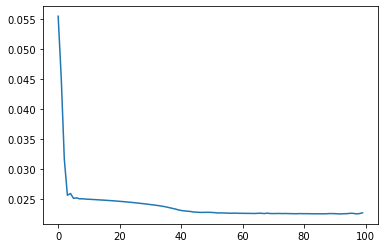

In [24]:
import numpy as np
import matplotlib.pyplot as plt
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [25]:
test_input = np.load(files['testing'][0])

In [26]:
decoded_data = autoencoder.predict(np.array([test_input]))

In [88]:
decoder = Model(data_inputs,decoded)

In [89]:
decoded_data = decoder.predict(np.array([test_inputs[1]]))

In [27]:
decoded_data.shape

(1, 128, 128, 1)

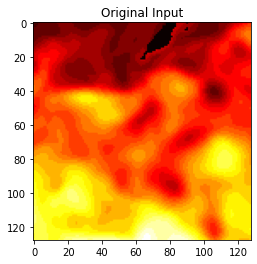

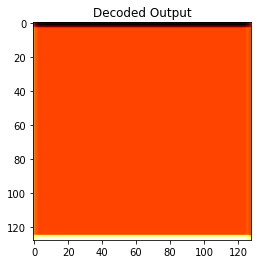

In [29]:
plt.imshow(test_input[:,:,0],cmap='hot')
plt.title('Original Input')
plt.show()
plt.imshow(decoded_data[0,:,:,0],cmap='hot')
plt.title('Decoded Output')
plt.show()